# Test 2 on TESS data 

Test 2 on TESS data aims to examine the performance of a random forest without considering the follow-up characteristics

In [41]:
import pandas as pd
import sys
import os

# Added paths to import modules
sys.path.insert(0, os.path.abspath('../'))

# import custom modules
from data_processing.distribution import (plot_class_distribution, plot_feature_importances,
                                          plot_scatter_feature_distributions, 
                                          plot_hist_feature_distributions,
                                          plot_hist_feature_distributions_0_1,
                                          compute_train_0_1)
from data_processing.data_analysis import (compute_all_columns_nan, print_nan_numbers_for_features,
                                           threshold_delete_nan)
from data_processing.data_balancing import smote_oversampling
from data_processing.data_scaling import plot_top_7_difference, data_scaling_normalization
from data_processing.features_prosessing import remove_non_numeric_columns, rows_id_nan, remove_nan_label
from data_processing.knn_imputer import k_nearest_neighbors_imputer
from data_processing.replace_disposition import replace_label
from dimensionality_reduction.features_selection import compute_feature_importance, feature_selection_rfc
from model_selection.grid_search import grid_search_param_optimization
from utils.mission import Mission
from utils.plot_style import PlotStyle
from utils.util import print_count_nan, print_feature_importance

# Read Data

read the csv file taken from:
1. TESS: ExoFOP https://exofop.ipac.caltech.edu/tess/view_toi.php

In [42]:
tess_data = pd.read_csv('../data/raw_data/tess_exofop.csv')
print('Shape of ExoFOP TESS data:', tess_data.shape)
_ = print_count_nan(data=tess_data, name='TESS')

Shape of ExoFOP TESS data: (6977, 62)
Number of NaN values in TESS: 38201 out of 432574: 8.83%


# Replace Label

In the data initially there is an disposition that includes 3 or more classes.

TESS: Disposizione TFOPWG
1. APC = Candidato Planetario Ambiguo
2. CP = Pianeta Confermato
3. FA = Falso Allarme
4. FP = Falso Positivo
5. KP = Pianeta Conosciuto
6. PC = Candidato Planetario

with the aim of making a binary classifier we use the following procedure to replace:
1. KP, CP, PC with the label: 1
2. APC, FA, FP with the label: 0

NASA Exoplanet Archive documentation: https://exoplanetarchive.ipac.caltech.edu/docs/API_TOI_columns.html 

ExoFOP documentation: https://exofop.ipac.caltech.edu/tess/tsm.php

In [43]:
tess_data = replace_label(data=tess_data, mission=Mission.TESS)
print('Shape of TESS data: ', tess_data.shape)

Shape of TESS data:  (6977, 62)


# Feature and Label Processing

The Kepler and TESS data have different features, so we want to find an intersection between the two sets of data. To do this, we perform several operations:

1. Removing non-numeric features
2. Removing of identifying characteristics
3. Identifying the labels (X_train, y_train)
4. Removing NaN in y_train and correspondingly also the X_train rows (if there are)

In [44]:
tess_data, non_numeric_columns = remove_non_numeric_columns(df=tess_data)
print('Non numric columns removed:', non_numeric_columns)

Non numric columns removed: ['Previous CTOI', 'TESS Disposition', 'Source', 'Detection', 'RA', 'Dec', 'Sectors', 'Date TOI Alerted (UTC)', 'Date TOI Updated (UTC)', 'Date Modified', 'Comments']


In [45]:
col = ['TOI', 'TIC ID', 'Pipeline Signal ID', 'Imaging Observations',
       'Spectroscopy Observations', 'Time Series Observations', 'SG3',
       'SG5', 'SG2', 'SG4', 'Master', 'SG1B', 'SG1A']
tess_data = tess_data.drop(columns=col, axis=1)

In [46]:
y_train = tess_data['TFOPWG Disposition']
tess_data = tess_data.drop(columns='TFOPWG Disposition')
X_train = tess_data

In [47]:
print('Shape of X_test_tess data: ', X_train.shape)
print('Shape of y_test_tess data: ', y_train.shape)
_ = print_count_nan(data=tess_data, name='TESS')

Shape of X_test_tess data:  (6977, 37)
Shape of y_test_tess data:  (6977,)
Number of NaN values in TESS: 31406 out of 258149: 12.17%


In [48]:
_ = print_count_nan(data=y_train, name='y_train')

Number of NaN values in y_train: 98 out of 6977: 1.40%


In this case there are 98 not a number in the labels so both the y_train and X_train rows are eliminated

In [49]:
# Removing NaN in y_train and correspondingly also the X_train rows
X_train, y_train = remove_nan_label(X_train, y_train)
count = y_train.isna().sum()
print('Shape of X_train data: ', X_train.shape)
print('Shape of y_train data: ', y_train.shape)
_ = print_count_nan(data=y_train, name='y_train')

Shape of X_train data:  (6879, 37)
Shape of y_train data:  (6879,)
Number of NaN values in y_train: 0 out of 6879: 0.00%


# Data Scaling

Nonostante non costituisca un prerequisito necessario nei modelli di machine learning, il processo di normalizzare i dati è tipicamente impiegato con l'obiettivo di:

1. Standardizzare l'intervallo di valori di tutte le caratteristiche del dataset
2. Migliorare la robustezza numerica degli algoritmi impiegati.

Per fare ciò viene utilizzato un modulo di scikit-learn StandardScaler il quale vuole standardizzare le caratteristiche rimuovendo la media e ridimensionandole alla varianza unitaria. Il punteggio standard di un campione x viene calcolato come:

$$
z = \frac{x - \mu}{\sigma}
$$

dove $\mu$ è la media dei campioni di addestramento o zero se with_mean=False, e $\sigma$ è la deviazione standard dei campioni di addestramento o uno se with_std=False.

La standardizzazione induce una variabile aleatoria distribuita secondo una media $\mu$ e varianza $\sigma^2$, ad una variabile aleatoria con distribuzione "standard", ossia di media zero e varianza unitaria.

Plot Before the scaling


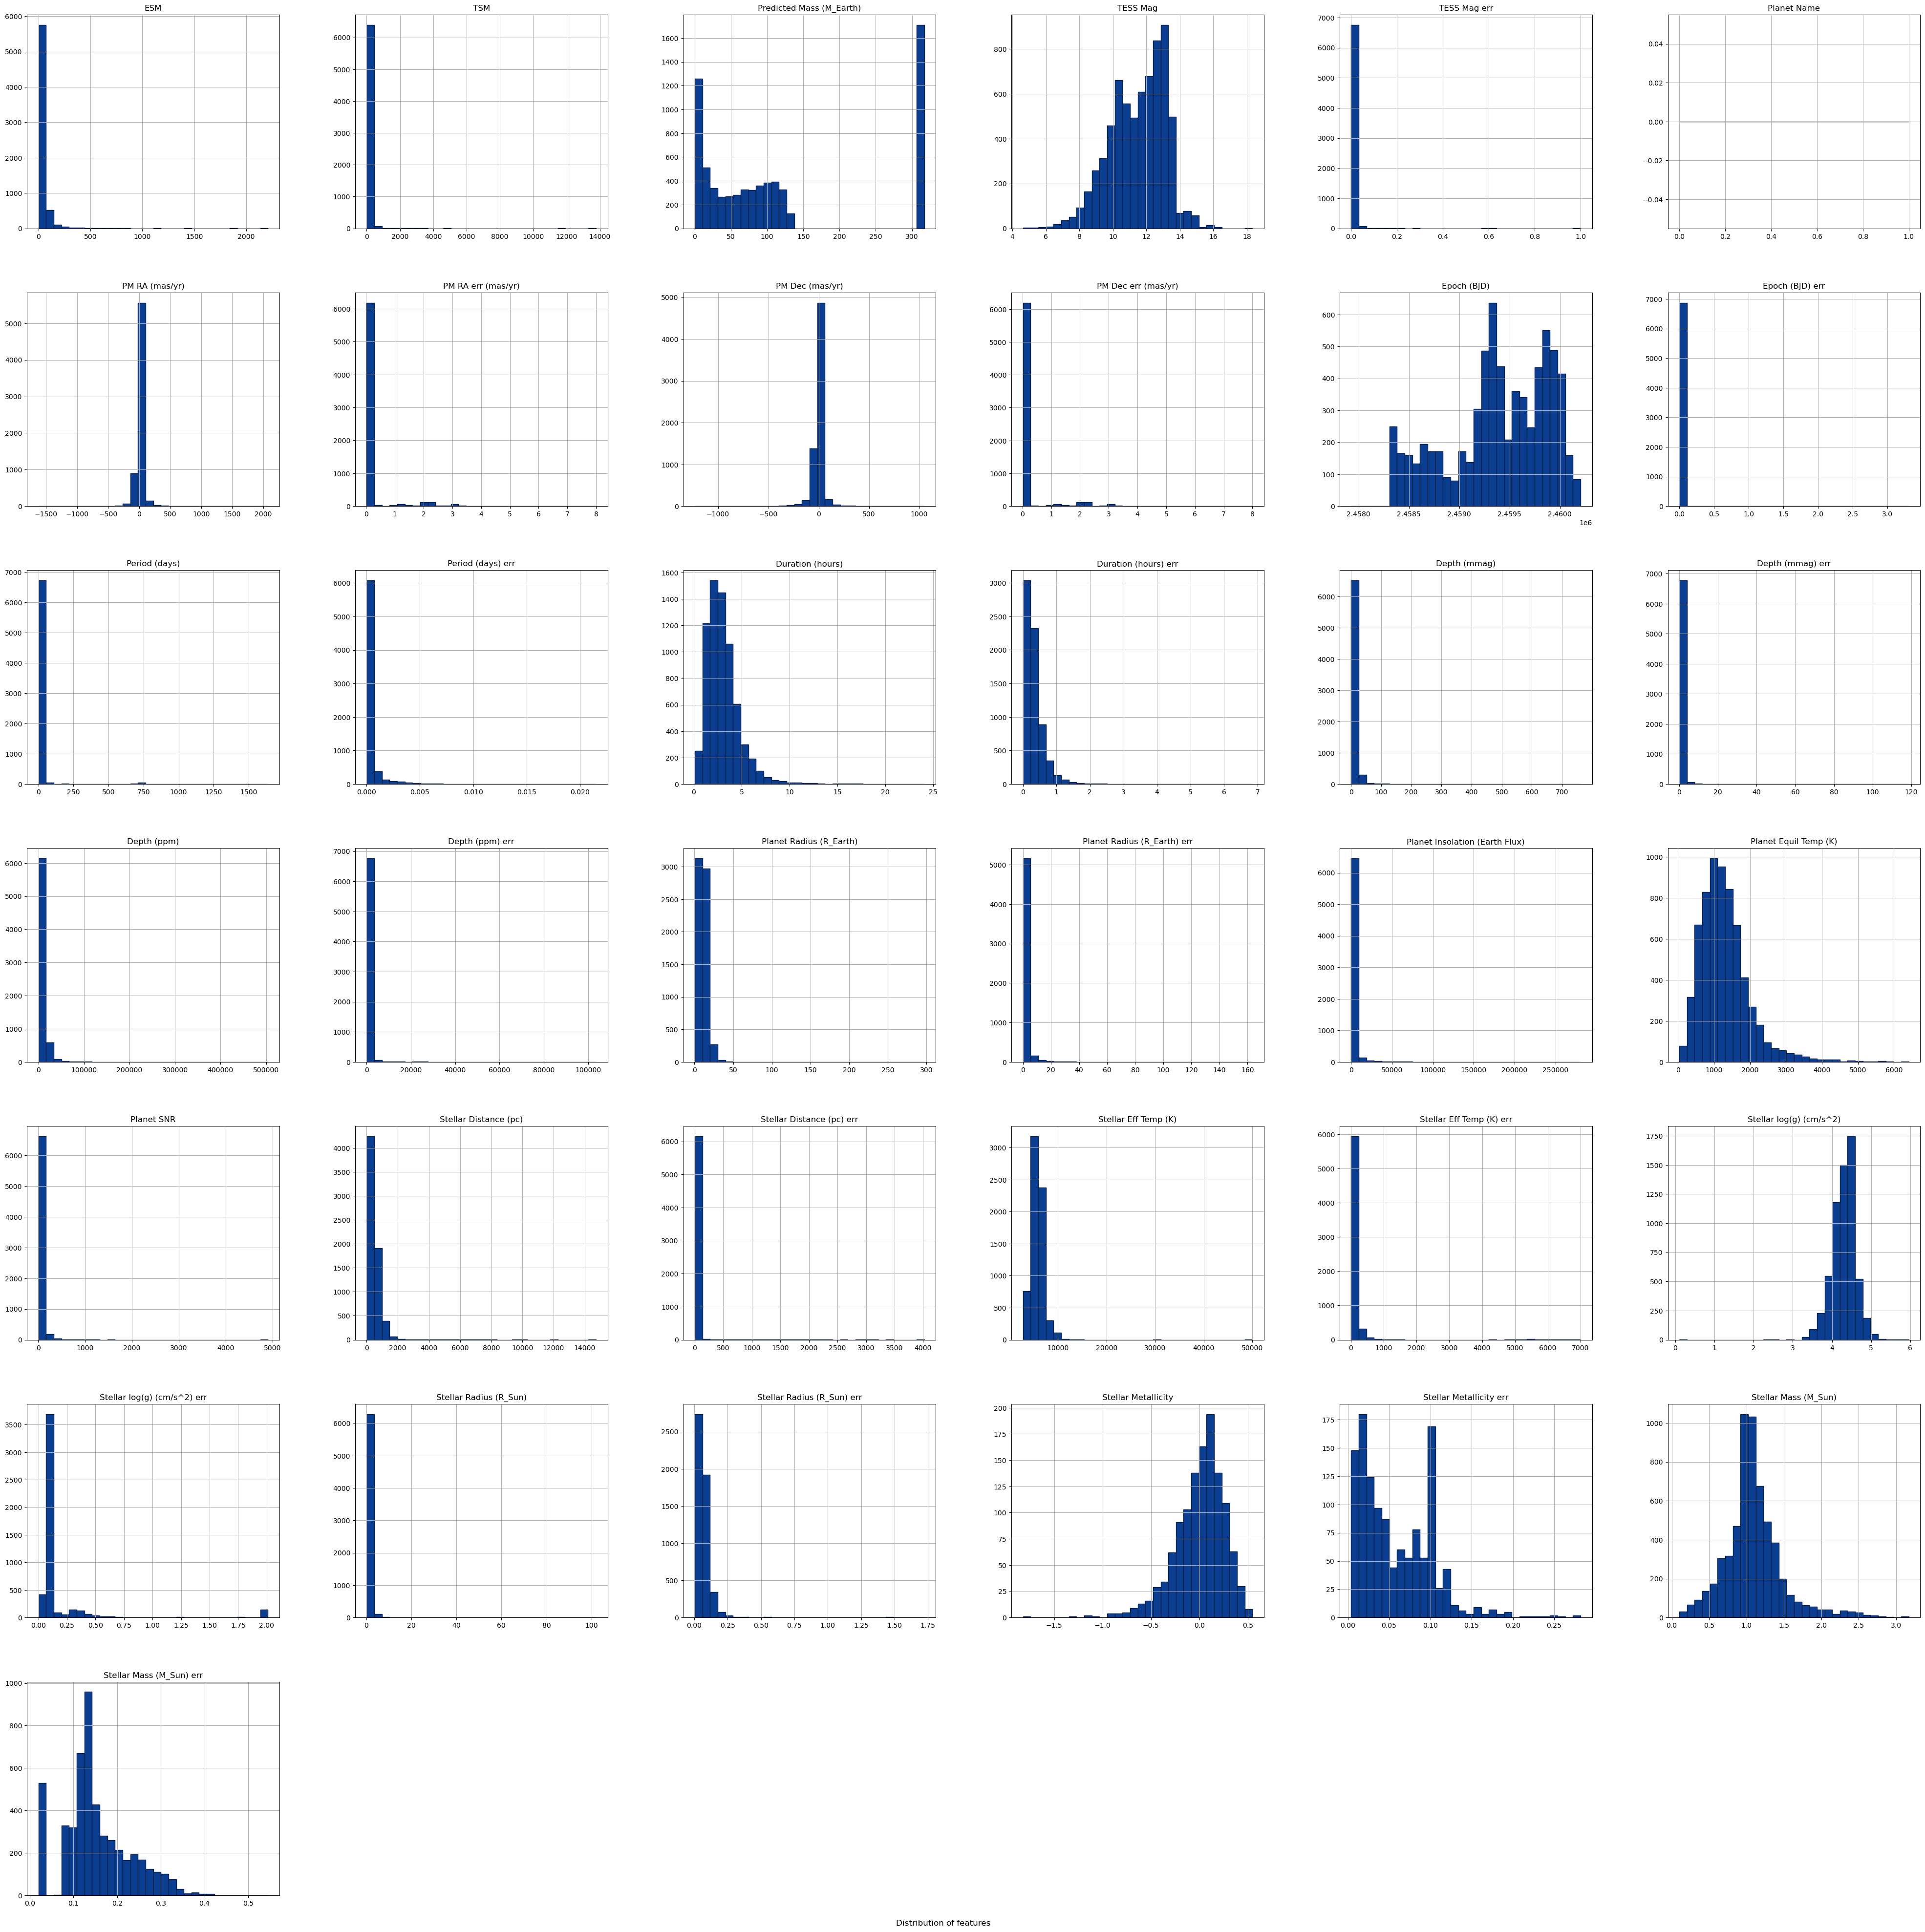

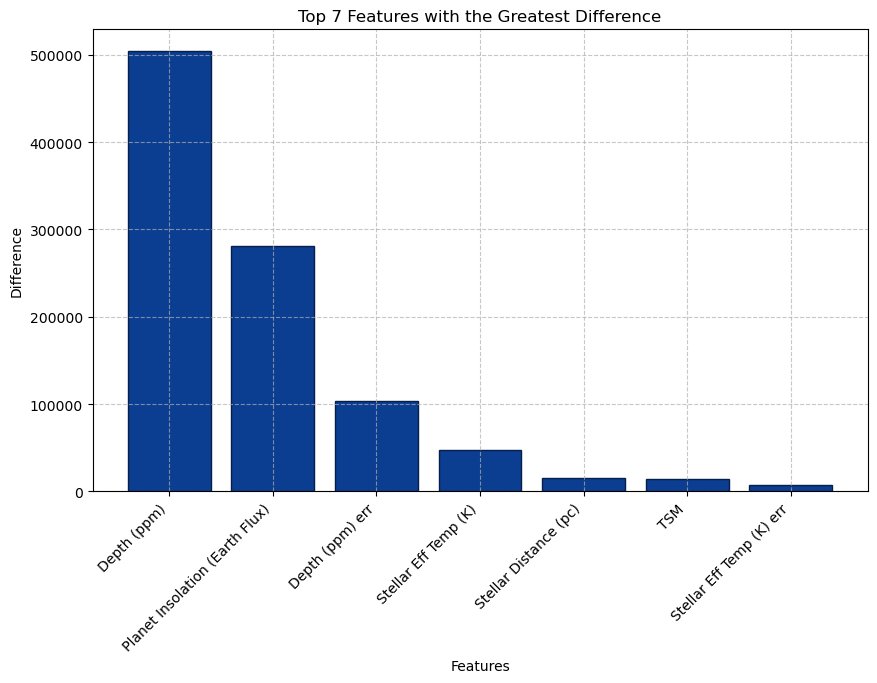

In [50]:
print('Plot Before the scaling')
plot_hist_feature_distributions(X_train=X_train)
plot_top_7_difference(X_train=X_train)

In [51]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_normalized, columns=X_train.columns)

/home/attilio/miniconda3/envs/env_tesi/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:479: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/home/attilio/miniconda3/envs/env_tesi/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:480: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


# K-Nearest Neighbors

The NaN problem must be managed carefully, there are several solutions that can be used, one of these is the KNN methodology which calculates a distance (e.g. Euclidean or Manhattan) between the observations and calculates the new value to be inserted with some methodologies (e.g. IDWM or IRWM) but considering the nearest K, where K is defined a priori, generally for K the square root of N is considered where N is the number of observations, or an approximation is used.

In this case, for efficiency reasons, the sklearn KNNImputer module was used which is optimized.

Dalla seguente operazione osserviamo che continuano a persistere in NaN in X_train

In [52]:
_ = print_count_nan(data=X_train, name='X_train')

Number of NaN values in X_train: 30978 out of 254523: 12.17%


In [53]:
# Calculate columns that contain only nan and the number of nan for each columns
nan_columns = compute_all_columns_nan(data=X_train)
number_of_nan_columns = {col: X_train[col].isna().sum() for col in X_train}
number_of_nan_columns = dict(sorted(number_of_nan_columns.items(), key=lambda x: x[1], reverse=True))
print_nan_numbers_for_features(data=X_train, number_of_nan_columns=number_of_nan_columns)

Columns containing only not a number in X_train: ['Planet Name']
Number of Observations: 6879
NaN for each feature
  1: Planet Name-------------------> 6879
  2: Stellar Metallicity-----------> 5661
  3: Stellar Metallicity err-------> 5661
  4: Stellar log(g) (cm/s^2) err---> 2001
  5: Stellar Mass (M_Sun) err------> 1874
  6: Stellar Radius (R_Sun) err----> 1717
  7: Planet Radius (R_Earth) err---> 1456
  8: Stellar Mass (M_Sun)----------> 915
  9: Stellar log(g) (cm/s^2)-------> 789
 10: Stellar Distance (pc) err-----> 637
 11: Planet Radius (R_Earth)-------> 467
 12: Stellar Radius (R_Sun)--------> 467
 13: Stellar Eff Temp (K) err------> 421
 14: ESM---------------------------> 383
 15: TSM---------------------------> 383
 16: Planet Equil Temp (K)---------> 279
 17: Stellar Distance (pc)---------> 202
 18: Planet Insolation (Earth Flux)> 155
 19: Stellar Eff Temp (K)----------> 130
 20: PM RA (mas/yr)----------------> 119
 21: PM RA err (mas/yr)------------> 119
 22: PM Dec (mas/

In [54]:
TCOL = 5000
nan_columns = threshold_delete_nan(number_of_nan_columns=number_of_nan_columns,
                                        nan_columns_name=nan_columns, threshold=TCOL)
X_train = X_train.drop(columns=nan_columns)
_ = print_count_nan(data=X_train, name='X_train')
print('Shape:', X_train.shape)

Number of NaN values in X_train: 12777 out of 233886: 5.46%
Shape: (6879, 34)


In [55]:
# Compute the number of not a number for each rows
number_of_nan_rows = X_train.isna().sum(axis=1)
TROW = 1
id_rows = rows_id_nan(number_of_nan_rows=number_of_nan_rows,
                      X_train=X_train, threshold=TROW)

Total rows >= of T=1: 2287 out of a total of 6879 By eliminating them you obtain 4592 observations


In [56]:
# Drop rows >= T
X_train = X_train.drop(id_rows).reset_index(drop=True)
y_train = y_train.drop(id_rows).reset_index(drop=True)
print('Shape of X_train:', X_train.shape)
_ = print_count_nan(data=X_train, name='X_train')

Shape of X_train: (4592, 34)
Number of NaN values in X_train: 0 out of 156128: 0.00%


In [57]:
INDEX_OF_K = 10
# Using KNNImputer
X_train = k_nearest_neighbors_imputer(X_train, INDEX_OF_K)
print('Shape of X_train:', X_train.shape)
_ = print_count_nan(data=X_train, name='X_train')
print('Shape of X_train data: ', X_train.shape)
print('Shape of y_train data: ', y_train.shape)

Number of NaN values in X_train: 0 out of 156128: 0.00%
There are no NaN
Shape of X_train: (4592, 34)
Number of NaN values in X_train: 0 out of 156128: 0.00%
Shape of X_train data:  (4592, 34)
Shape of y_train data:  (4592,)


Plot After the scaling and KNNImputer


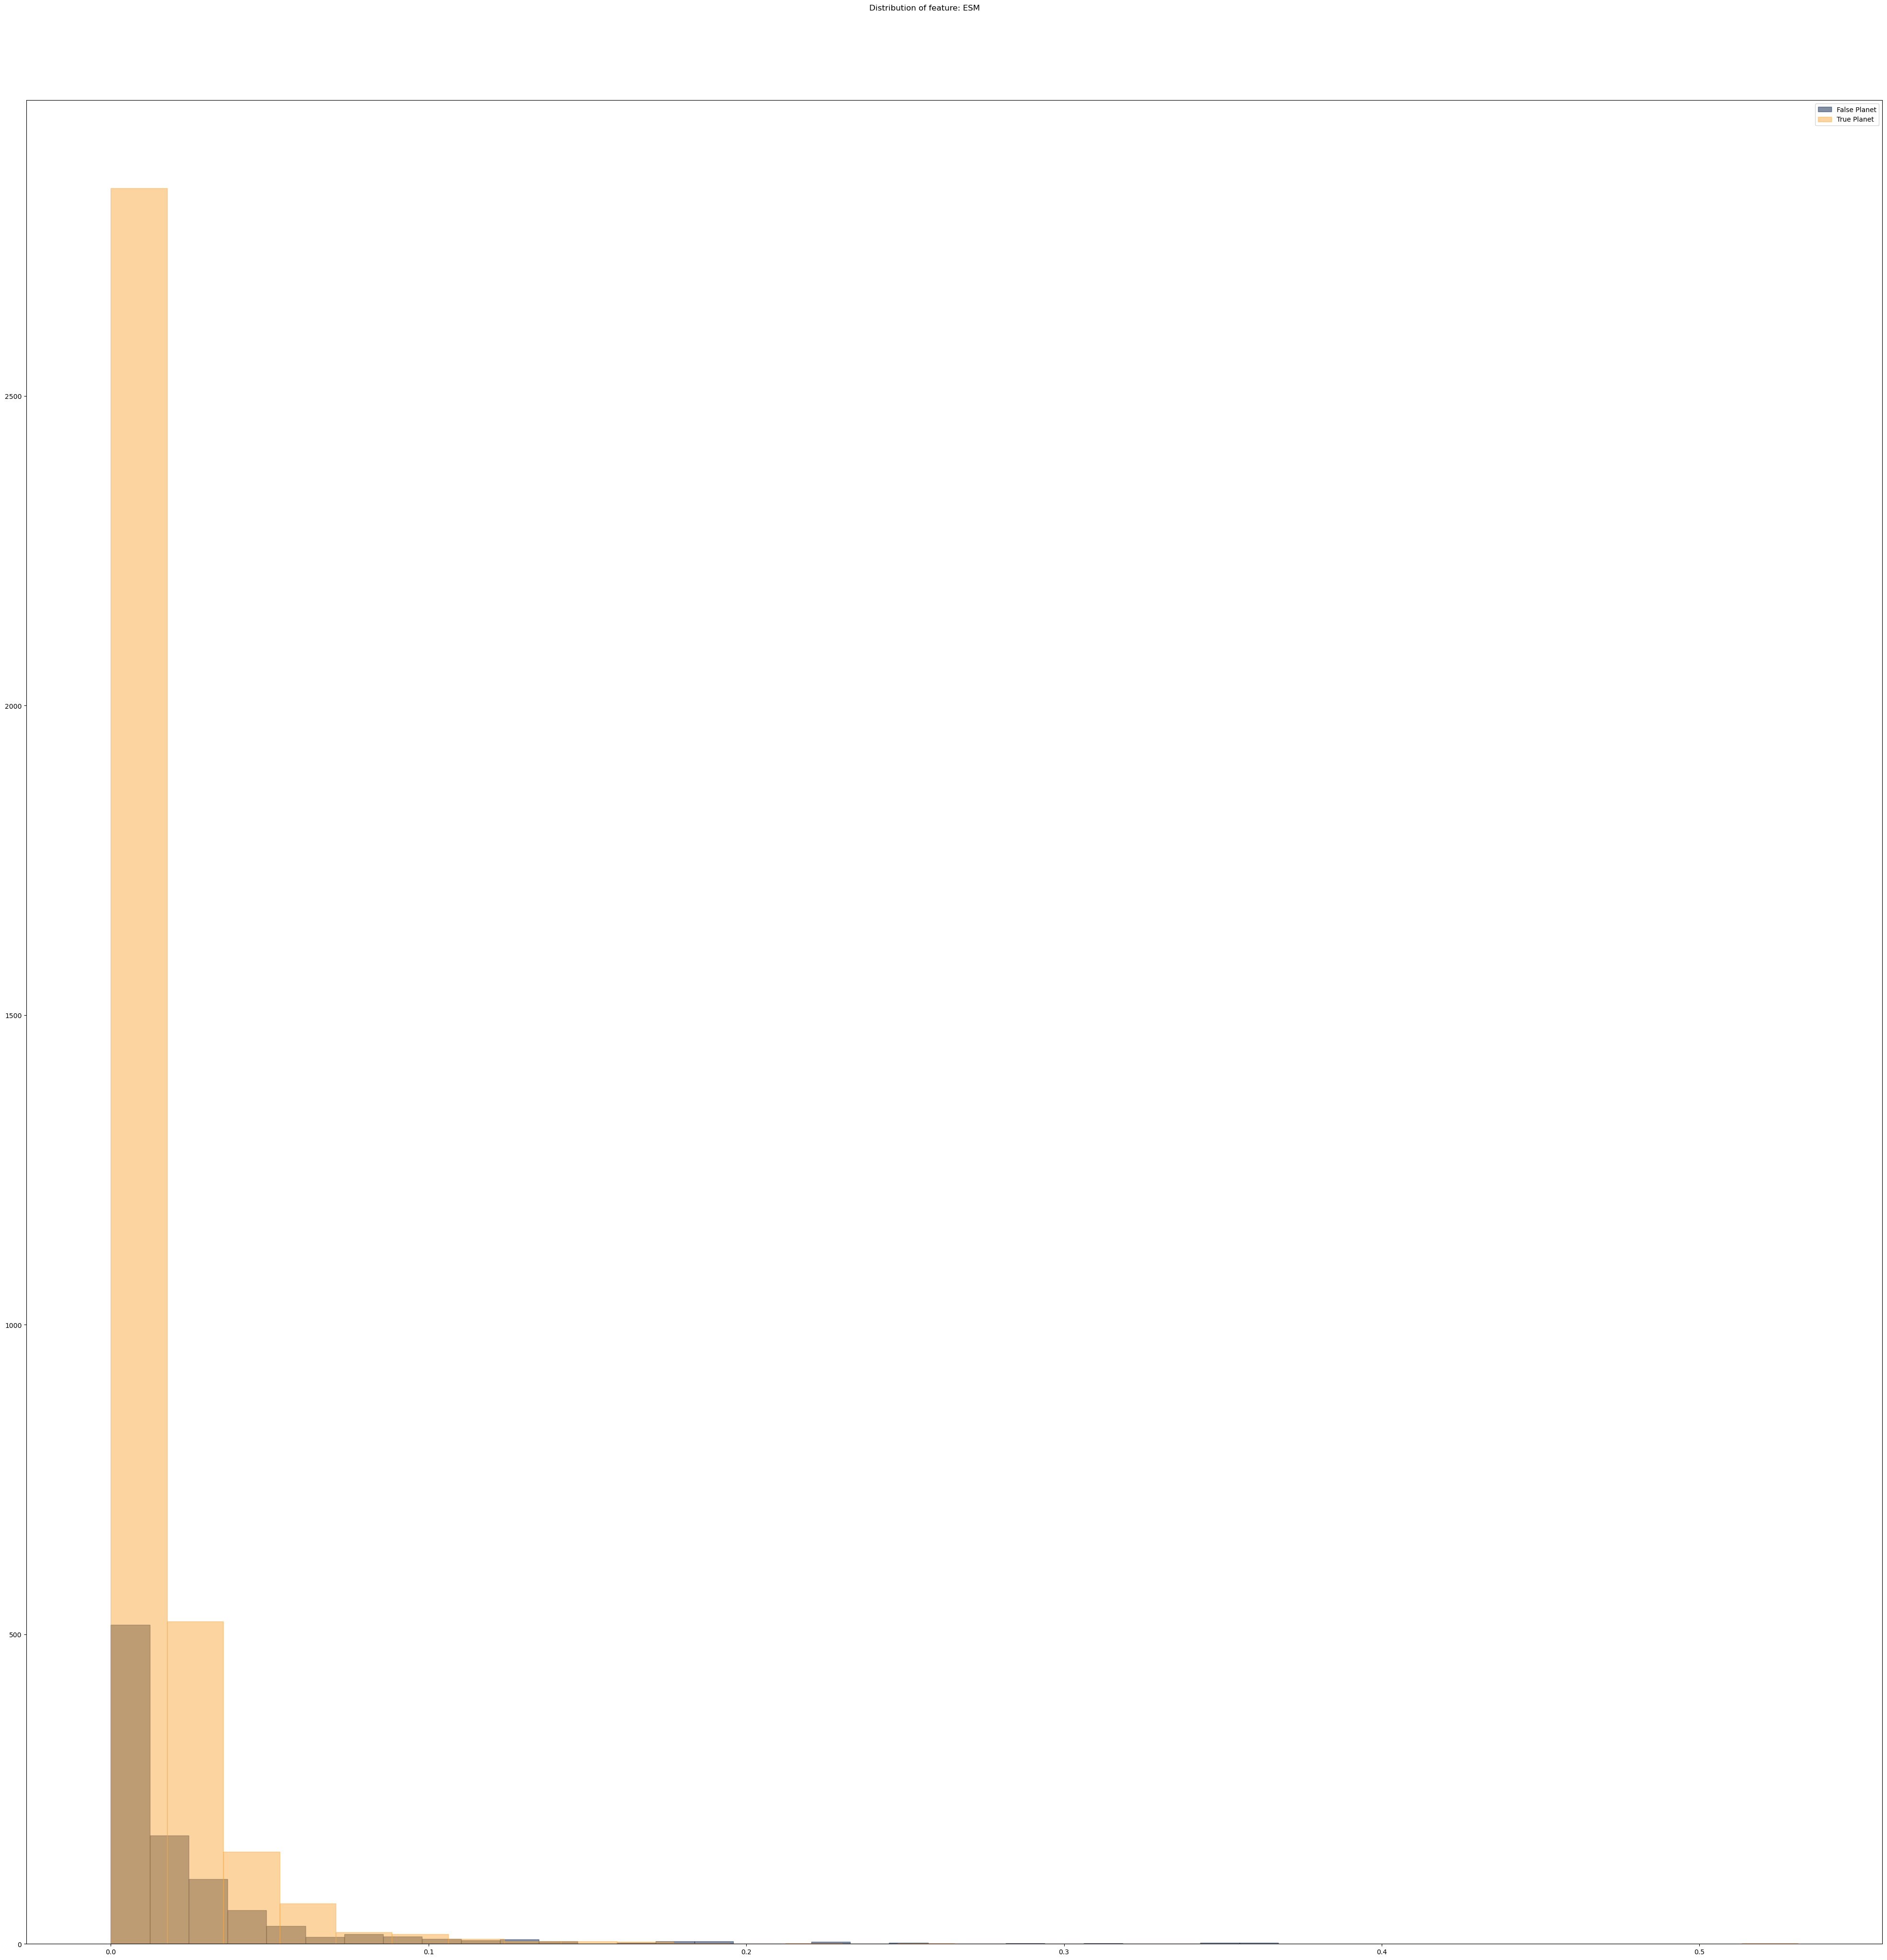

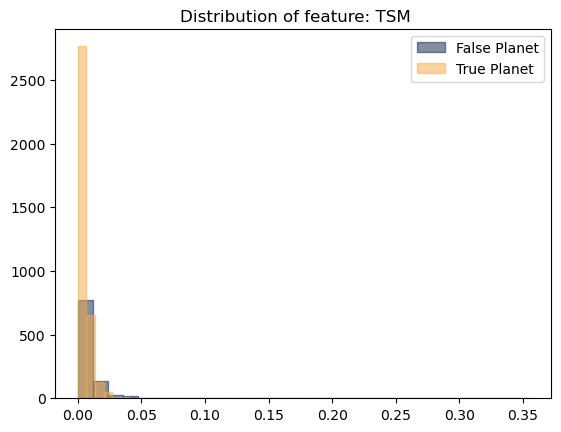

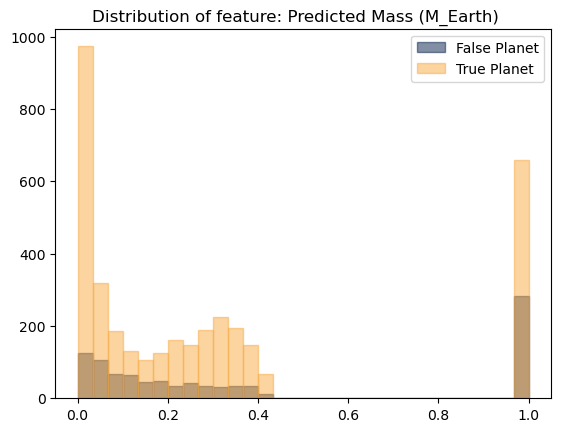

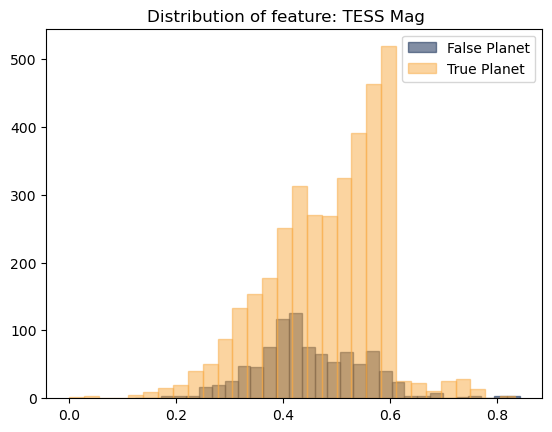

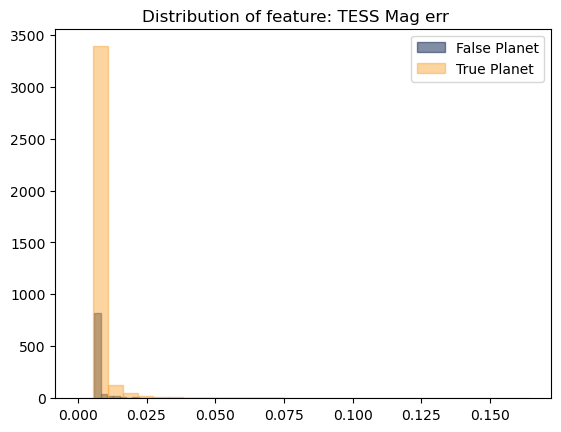

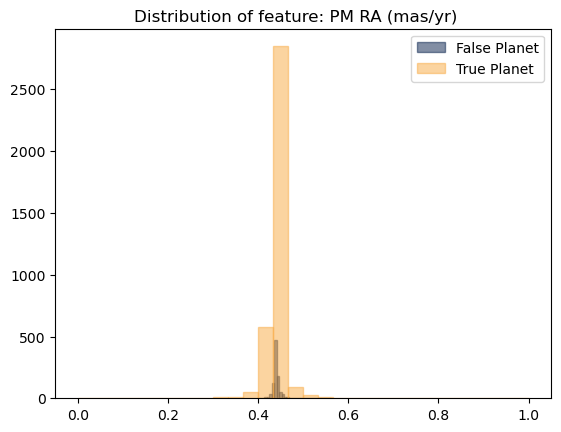

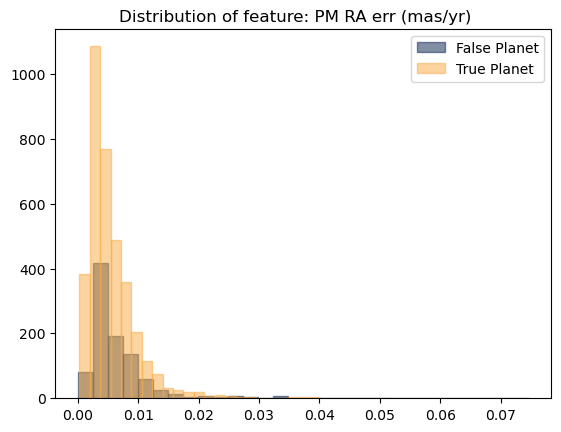

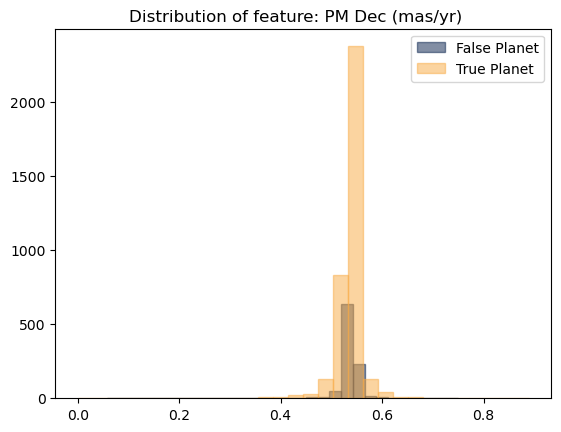

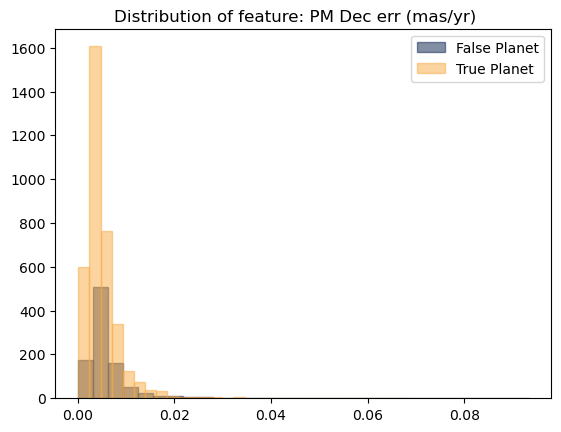

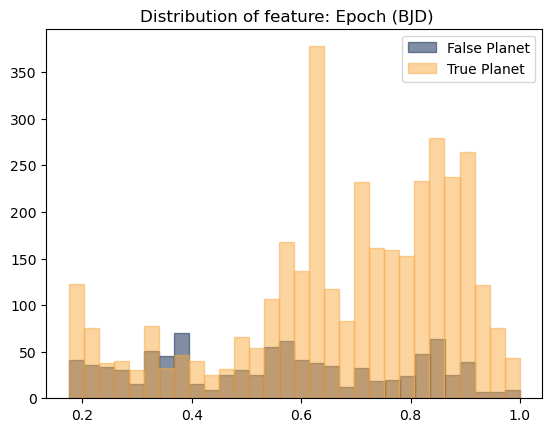

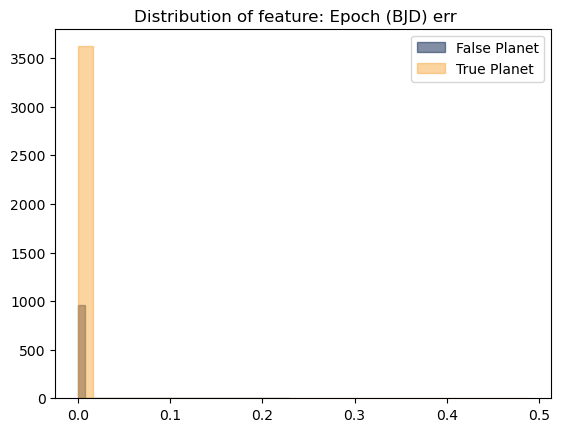

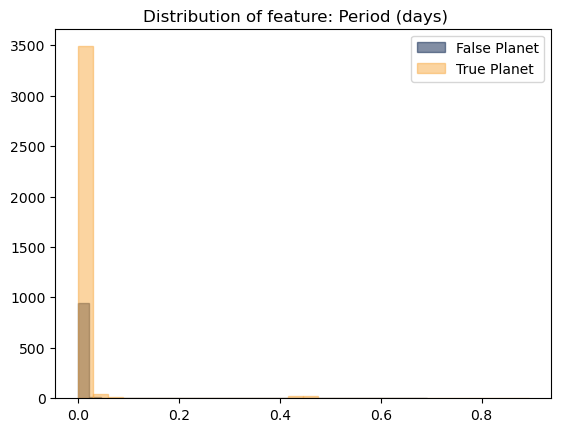

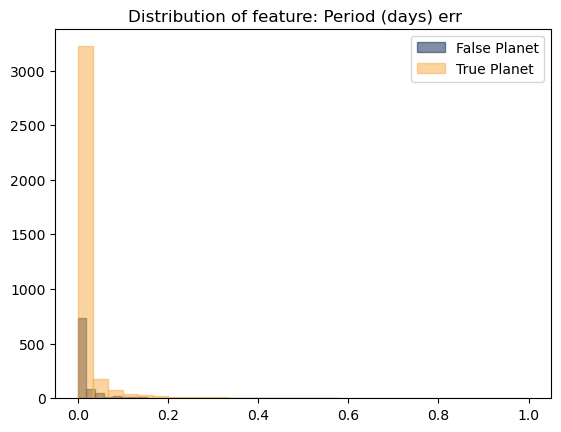

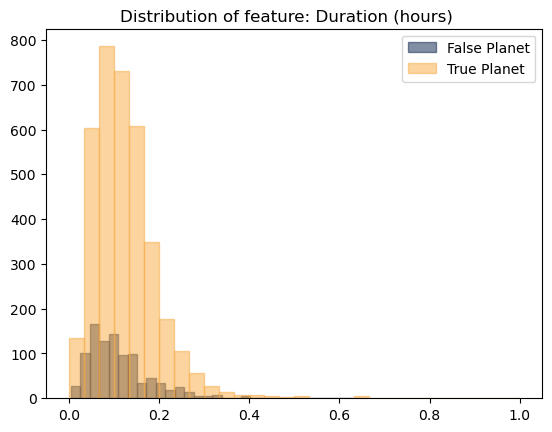

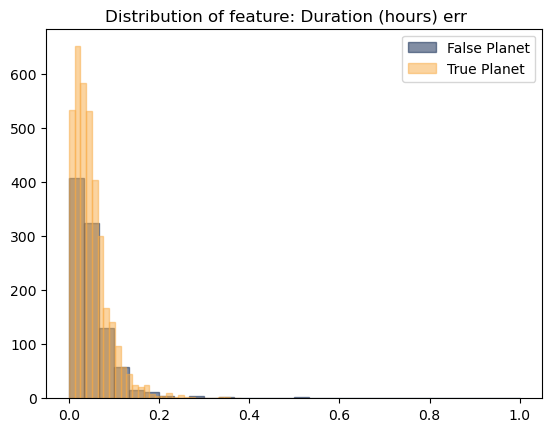

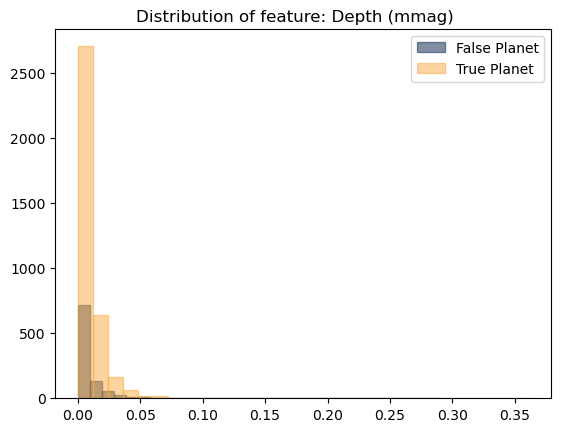

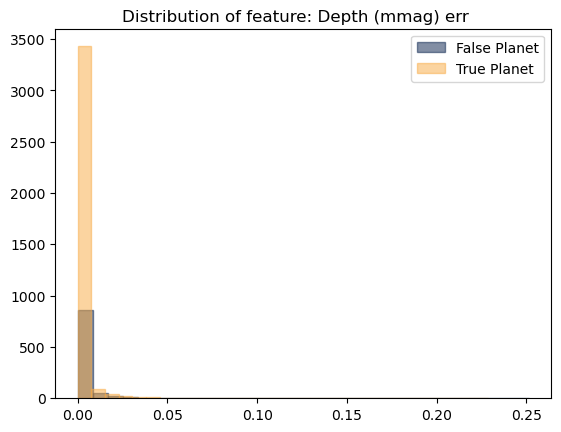

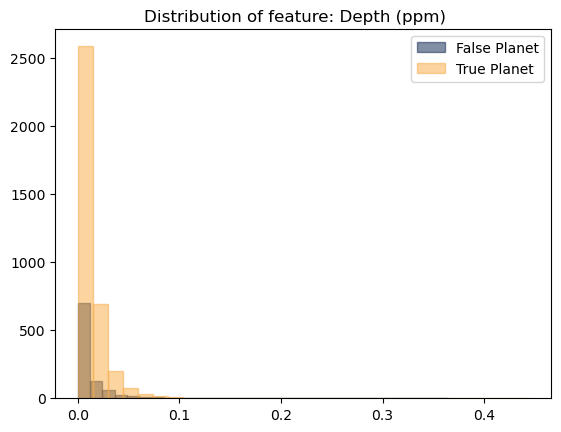

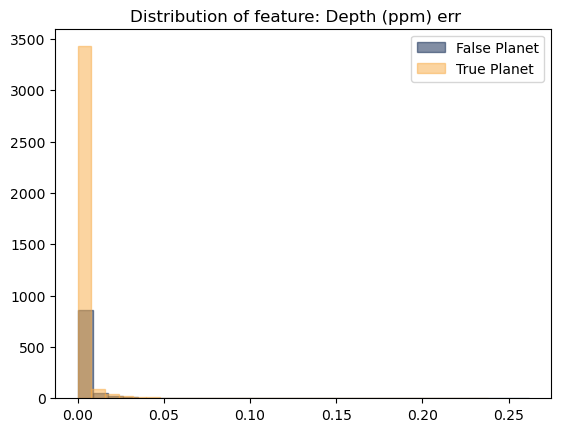

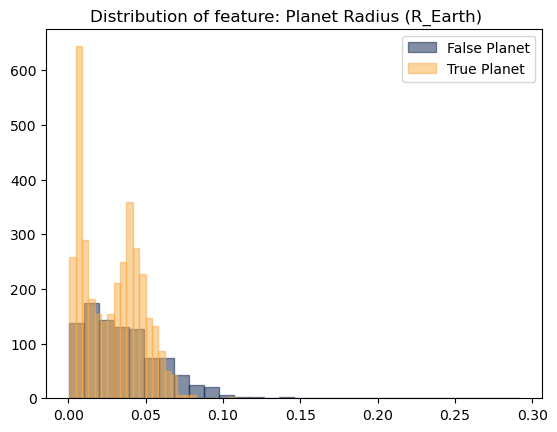

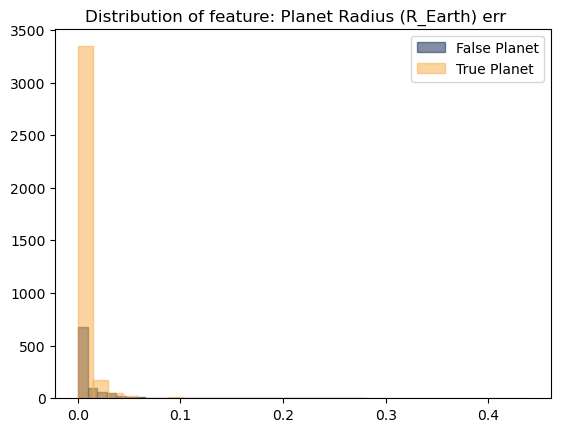

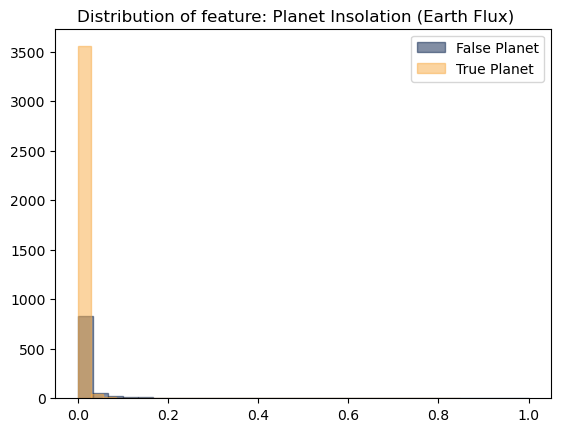

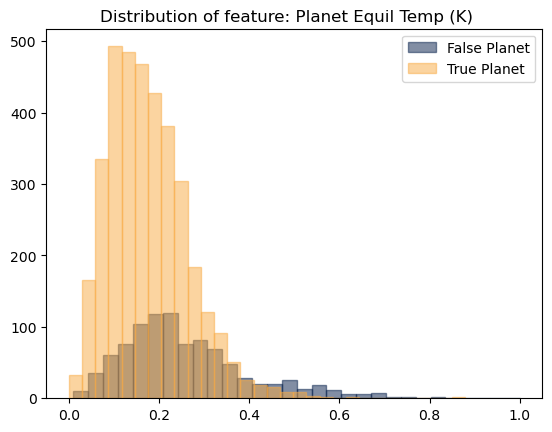

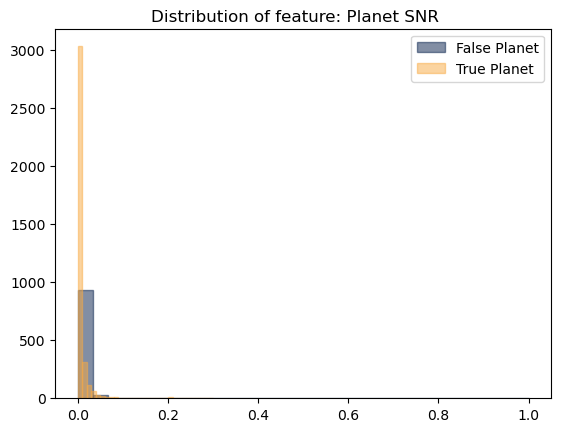

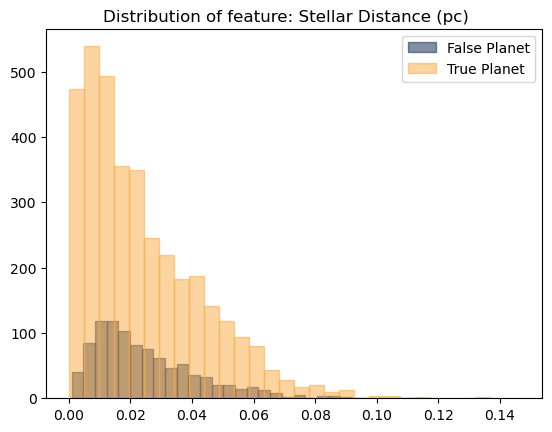

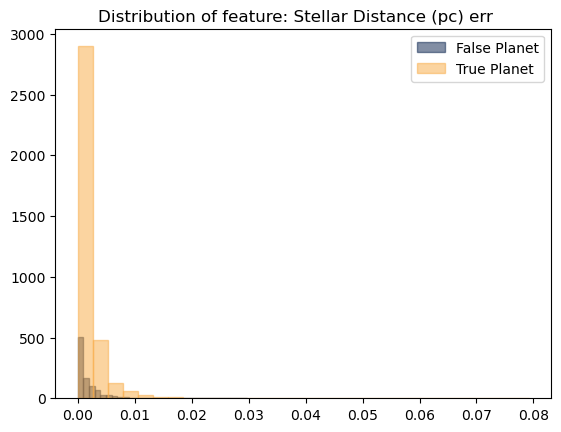

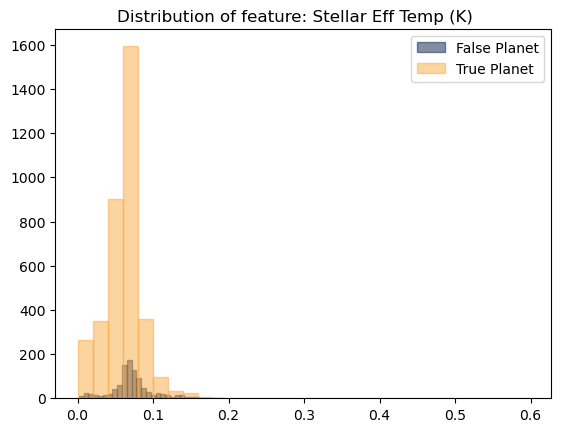

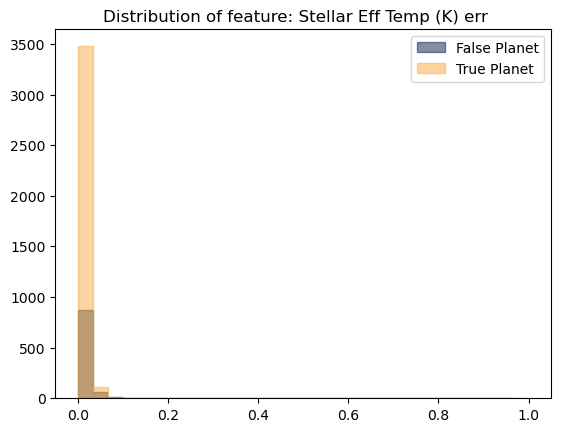

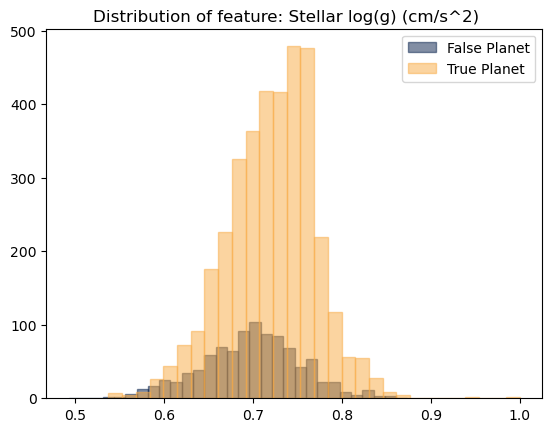

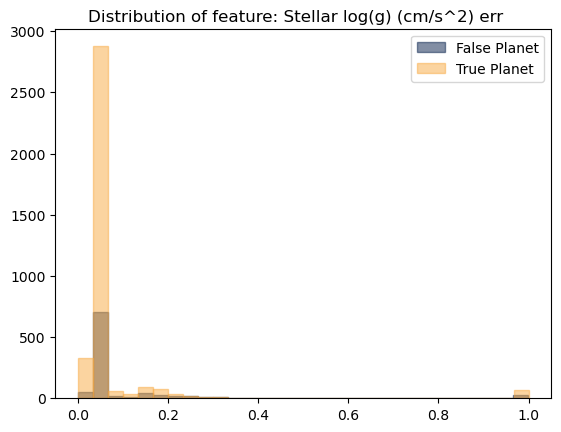

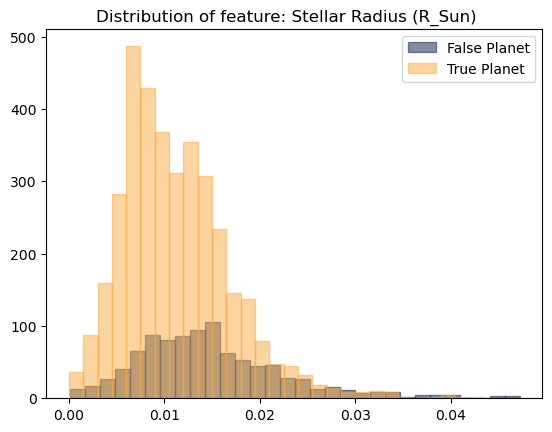

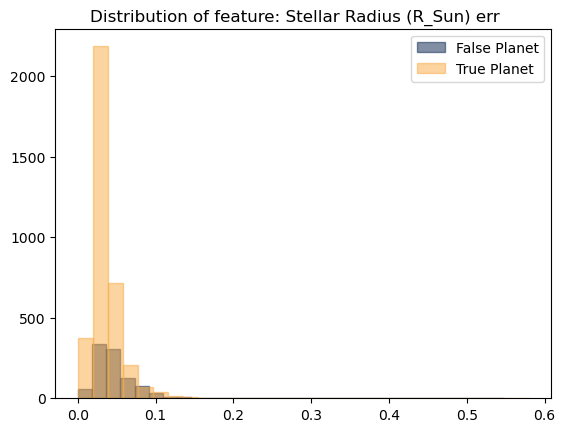

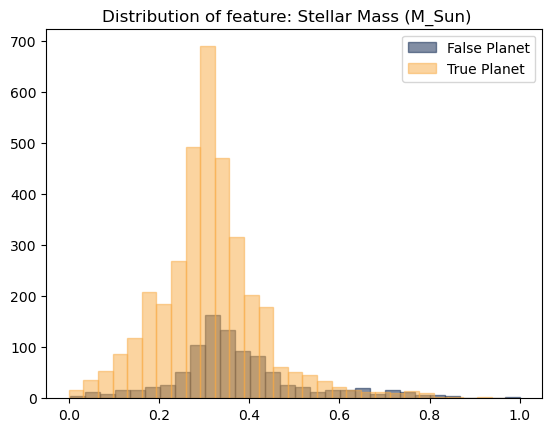

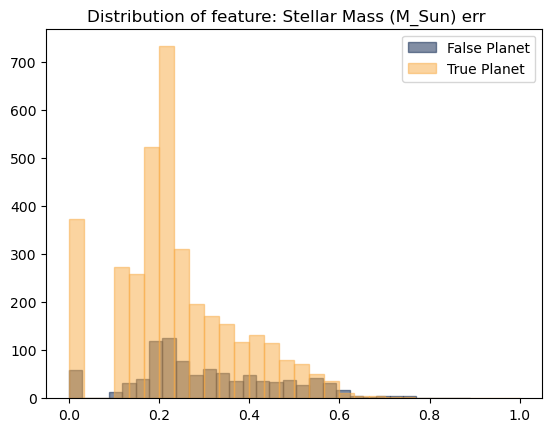

In [58]:
print('Plot After the scaling and KNNImputer')
# plot_top_7_difference(X_train=X_train)
# plot_hist_feature_distributions(X_train=X_train)
X_train_0, X_train_1 = compute_train_0_1(X_train=X_train, y_train=y_train)
# plot_hist_feature_distributions(X_train=X_train_0)
# plot_hist_feature_distributions(X_train=X_train_1)
plot_hist_feature_distributions_0_1(X_train_0=X_train_0, X_train_1=X_train_1)

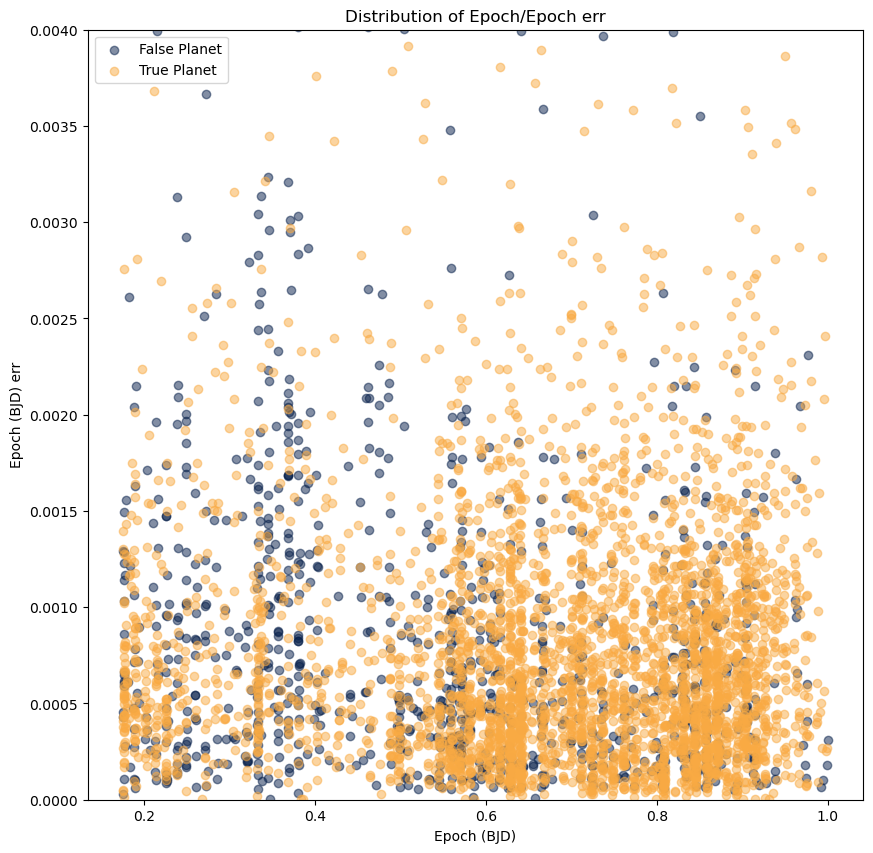

In [59]:
import matplotlib.pyplot as plt
from utils.color import Color

plt.figure(figsize=(10, 10))
plt.scatter(X_train_0['Epoch (BJD)'], X_train_0['Epoch (BJD) err'], color=Color.SPACE.value,
            label='False Planet', alpha=0.5)
plt.scatter(X_train_1['Epoch (BJD)'], X_train_1['Epoch (BJD) err'], color=Color.SUN.value,
            label='True Planet', alpha=0.5)
plt.xlabel('Epoch (BJD)')
plt.ylabel('Epoch (BJD) err')
plt.title('Distribution of Epoch/Epoch err')
plt.legend()
plt.ylim(-0.000,0.004)
plt.show()

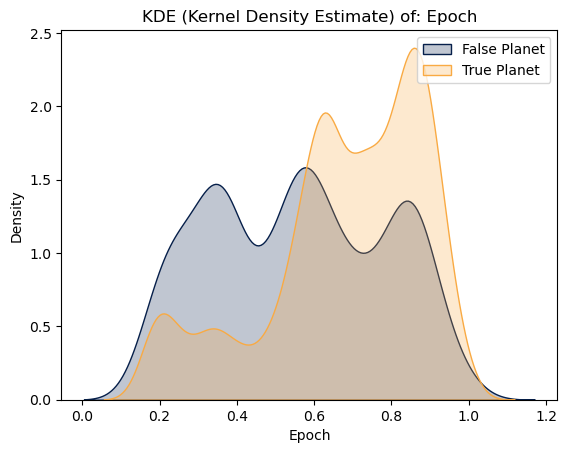

In [60]:
import seaborn as sns

sns.kdeplot(X_train_0['Epoch (BJD)'], color=Color.SPACE.value,
            label='False Planet', fill=True)
sns.kdeplot(X_train_1['Epoch (BJD)'], color=Color.SUN.value,
            label='True Planet', fill=True)
plt.xlabel('Epoch')
plt.ylabel('Density')
plt.title('KDE (Kernel Density Estimate) of: Epoch')
plt.legend()
plt.show()

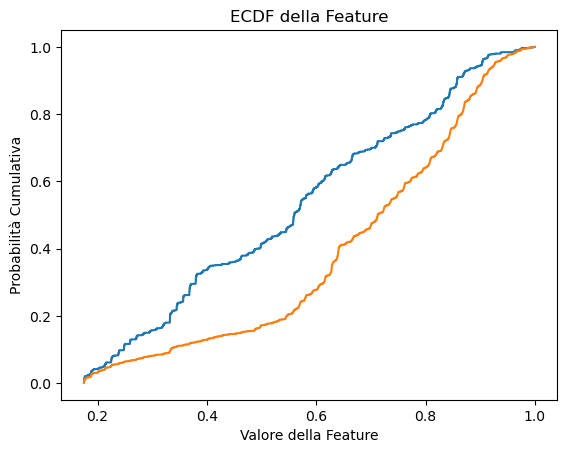

In [61]:
import numpy as np

# Calcolo dell'ECDF
sorted_data = np.sort(X_train_0['Epoch (BJD)'])
sorted_data2 = np.sort(X_train_1['Epoch (BJD)'])
ecdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
ecdf2 = np.arange(1, len(sorted_data2) + 1) / len(sorted_data2)

# Creazione del plot dell'ECDF
plt.step(sorted_data, ecdf)
plt.step(sorted_data2, ecdf2)

# Aggiungi etichette agli assi
plt.xlabel('Valore della Feature')
plt.ylabel('Probabilità Cumulativa')

# Aggiungi un titolo al grafico
plt.title('ECDF della Feature')

# Mostra il grafico
plt.show()
